Book Recommender System


In [1]:
#importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, ImageColorGenerator
import string
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from spacy import displacy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, average_precision_score


In [2]:
#reading the files
books = pd.read_csv('data/books.csv', encoding = "ISO-8859-1")
books.head()

,id,book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPrÃ©",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [3]:
books.shape

(10000, 23)

The books table has 10,000 observations and 23 columns.

In [4]:
book_tags = pd.read_csv('data/book_tags.csv', encoding = "ISO-8859-1")
book_tags.head()

,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


In [5]:
book_tags.shape

(999912, 3)

The book tags table has 999912 observations and 3 columns

In [6]:
ratings = pd.read_csv('data/ratings.csv', encoding = "ISO-8859-1")
ratings.head()


,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


In [7]:
ratings.shape

(981756, 3)

In [8]:
tags = pd.read_csv('data/tags.csv', encoding = "ISO-8859-1")
tags.head()

,tag_id,tag_name
0,0,-
1,1,--1-
2,2,--10-
3,3,--12-
4,4,--122-


In [9]:
tags.shape

(34252, 2)

The tags table has 34252 rows and 2 columns

In [10]:
to_read = pd.read_csv('data/to_read.csv', encoding = "ISO-8859-1")
to_read.head()

,user_id,book_id
0,1,112
1,1,235
2,1,533
3,1,1198
4,1,1874


In [11]:
to_read.shape

(912705, 2)

The table to_read has 912705 observations and 2 columns

## Exploratory data analysis
Let's see various distributions of the data
1. Missing values

In [12]:
books.isna().mean()

id                           0.0000
book_id                      0.0000
best_book_id                 0.0000
work_id                      0.0000
books_count                  0.0000
isbn                         0.0700
isbn13                       0.0585
authors                      0.0000
original_publication_year    0.0021
original_title               0.0585
title                        0.0000
language_code                0.1084
average_rating               0.0000
ratings_count                0.0000
work_ratings_count           0.0000
work_text_reviews_count      0.0000
ratings_1                    0.0000
ratings_2                    0.0000
ratings_3                    0.0000
ratings_4                    0.0000
ratings_5                    0.0000
image_url                    0.0000
small_image_url              0.0000
dtype: float64

Language code, isbn and original title have missing values. We can drop rows where original title is missing

In [13]:
book_tags.isna().mean()

goodreads_book_id    0.0
tag_id               0.0
count                0.0
dtype: float64

In [14]:
ratings.isna().mean()

book_id    0.0
user_id    0.0
rating     0.0
dtype: float64

In [15]:
tags.isna().mean()

tag_id      0.0
tag_name    0.0
dtype: float64

In [16]:
to_read.isna().mean()

user_id    0.0
book_id    0.0
dtype: float64

Rest of the tables do nto have any missing values. Let's also remove the duplicate values.

In [17]:
ratings.drop_duplicates(subset =["user_id","book_id"], 
                     keep = False, inplace = True) 
ratings.shape

(977269, 3)

 4487 duplicates were removed

In [18]:
print(books.shape)
books.drop_duplicates(subset='original_title',keep=False,inplace=True)
print(books.shape)

(10000, 23)
(9151, 23)


849 rows removed.

In [19]:
print(tags.shape)
tags.drop_duplicates(subset='tag_id',keep=False,inplace=True)
print(tags.shape)

(34252, 2)
(34252, 2)


There are no duplicates in tags.

In [20]:
print(book_tags.shape)
book_tags.drop_duplicates(subset=['tag_id','goodreads_book_id'],keep=False,inplace=True)
print(book_tags.shape)

(999912, 3)
(999896, 3)


### Visualization

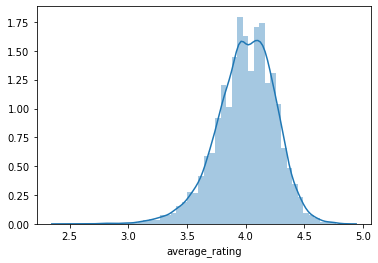

In [21]:
sns.distplot(a=books['average_rating'], kde=True);

Most of the average ratings fall between 3.5-4.5

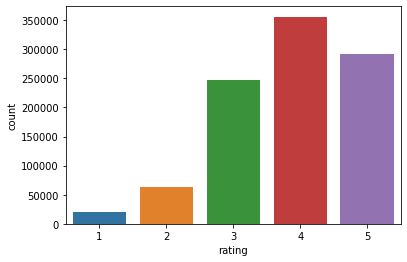

In [22]:
fig=sns.countplot(x=ratings['rating']);

Most of the ratings fall between 3-5

In [23]:
top_rated=books.sort_values('average_rating', ascending=False)
top10=top_rated.head(10)
f=['title','small_image_url']
displ=(top10[f])
displ.set_index('title', inplace=True)

In [24]:
import pandas as pd
from IPython.display import Image, HTML

def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''

    return '<img src="'+ path + '" style=max-height:124px;"/>'
pd.set_option('display.max_colwidth', -1)
HTML(displ.to_html(escape=False ,formatters=dict(small_image_url=path_to_image_html)))

,small_image_url
title,
The Complete Calvin and Hobbes,
"Words of Radiance (The Stormlight Archive, #2)",
Mark of the Lion Trilogy,
It's a Magical World: A Calvin and Hobbes Collection,
There's Treasure Everywhere: A Calvin and Hobbes Collection,
"Harry Potter Boxset (Harry Potter, #1-7)",
"Harry Potter Collection (Harry Potter, #1-6)",
The Indispensable Calvin and Hobbes,
The Authoritative Calvin and Hobbes: A Calvin and Hobbes Treasury,


Top 10 rated books

In [25]:
most_pop=books.sort_values('ratings_count', ascending=False)
pop10=most_pop.head(10)
f=['title','small_image_url']
displ1=(pop10[f])
displ1.set_index('title', inplace=True)

In [26]:
import pandas as pd
from IPython.display import Image, HTML

def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''

    return '<img src="'+ path + '" style=max-height:124px;"/>'
pd.set_option('display.max_colwidth', -1)
HTML(displ1.to_html(escape=False ,formatters=dict(small_image_url=path_to_image_html)))

,small_image_url
title,
"The Hunger Games (The Hunger Games, #1)",
"Harry Potter and the Sorcerer's Stone (Harry Potter, #1)",
To Kill a Mockingbird,
The Great Gatsby,
The Fault in Our Stars,
The Hobbit,
The Catcher in the Rye,
Pride and Prejudice,
"Angels & Demons (Robert Langdon, #1)",


Top 10 most popular books by ratings

In [27]:
authors=books.groupby('authors').agg({'average_rating':'mean','ratings_count':'sum'}).reset_index()
top_rated_authors=authors.sort_values('average_rating', ascending=False).head(10)[['authors','average_rating']]
most_pop_authors=authors.sort_values('ratings_count', ascending=False).head(10)[['authors','ratings_count']]

C:\Users\ambit\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:211: RuntimeWarning: Glyph 141 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\ambit\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:180: RuntimeWarning: Glyph 141 missing from current font.
  font.set_text(s, 0, flags=flags)


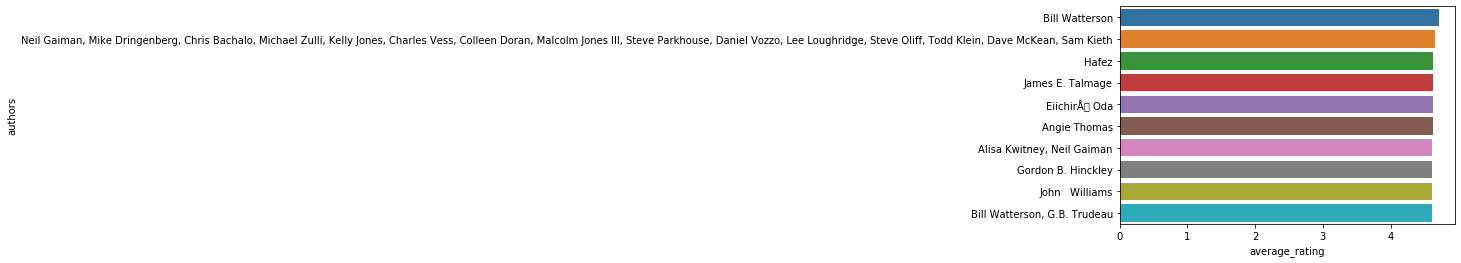

In [28]:
sns.barplot(data=top_rated_authors,x='average_rating',y='authors');

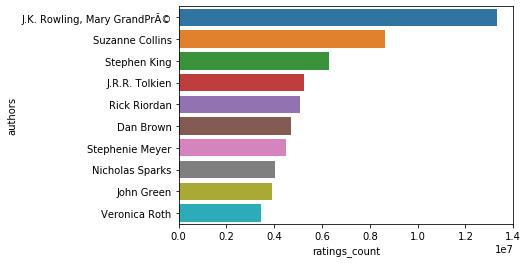

In [29]:
sns.barplot(data=most_pop_authors,x='ratings_count',y='authors');


Number of ratings per user

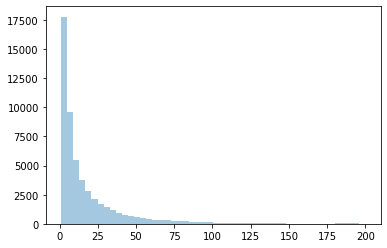

In [30]:
sns.distplot(ratings.groupby('user_id').agg({'rating':'count'}),kde=False)

Number of ratings per book

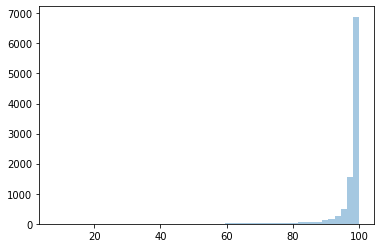

In [31]:
sns.distplot(ratings.groupby('book_id').agg({'rating':'count'}),kde=False);

Let's explore which genres are more famous

In [32]:
genres=["Art", "Biography", "Business", "Chick Lit", "Children's", "Christian", "Classics", "Comics", "Contemporary", "Cookbooks", "Crime", "Ebooks", "Fantasy", "Fiction", "Gay and Lesbian", "Graphic Novels", "Historical Fiction", "History", "Horror", "Humor and Comedy", "Manga", "Memoir", "Music", "Mystery", "Nonfiction", "Paranormal", "Philosophy", "Poetry", "Psychology", "Religion", "Romance", "Science", "Science Fiction", "Self Help", "Suspense", "Spirituality", "Sports", "Thriller", "Travel", "Young Adult"]
for i in range(len(genres)):
    genres[i]=genres[i].lower()

In [33]:
joint_tag=tags.merge(book_tags,on='tag_id',how='inner')
p=joint_tag.groupby('tag_name').count()
p=p.sort_values(by='count', ascending=False)

In [34]:
new_tags=p[p.index.isin(genres)]
#new_tags.reset_index()

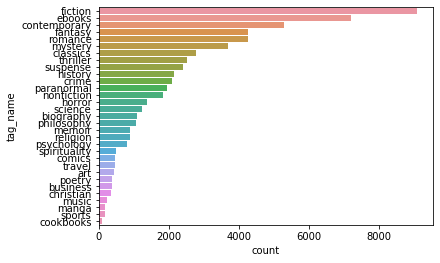

In [35]:

sns.barplot(x="count", y=new_tags.index,   data=new_tags);


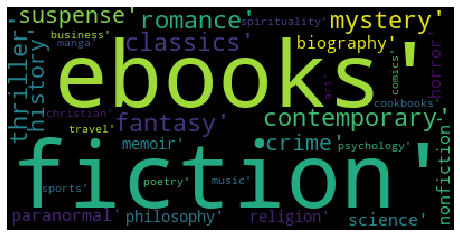

In [36]:
from wordcloud import WordCloud, STOPWORDS 
text = new_tags.index.values 

wordcloud = WordCloud().generate(str(text))
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Recommendation system
### 1.Content based

In [37]:
fillnabooks= books.fillna('')
def clean_data(x):
        return str.lower(x.replace(" ", ""))

In [38]:
features=['original_title','authors','average_rating']
fillednabooks=fillnabooks[features]

In [39]:
fillednabooks = fillednabooks.astype(str)
fillednabooks.dtypes

original_title    object
authors           object
average_rating    object
dtype: object

In [40]:
for feature in features:
    fillednabooks[feature] = fillednabooks[feature].apply(clean_data)
    
fillednabooks.head()

,original_title,authors,average_rating
0,thehungergames,suzannecollins,4.34
1,harrypotterandthephilosopher'sstone,"j.k.rowling,marygrandprã©",4.44
3,tokillamockingbird,harperlee,4.25
4,thegreatgatsby,f.scottfitzgerald,3.89
5,thefaultinourstars,johngreen,4.26


In [41]:
def create_soup(x):
    return x['original_title']+ ' ' + x['authors'] + ' ' + x['average_rating']

In [42]:
fillednabooks['soup'] = fillednabooks.apply(create_soup, axis=1)
fillednabooks

,original_title,authors,average_rating,soup
0,thehungergames,suzannecollins,4.34,thehungergames suzannecollins 4.34
1,harrypotterandthephilosopher'sstone,"j.k.rowling,marygrandprã©",4.44,"harrypotterandthephilosopher'sstone j.k.rowling,marygrandprã© 4.44"
3,tokillamockingbird,harperlee,4.25,tokillamockingbird harperlee 4.25
4,thegreatgatsby,f.scottfitzgerald,3.89,thegreatgatsby f.scottfitzgerald 3.89
5,thefaultinourstars,johngreen,4.26,thefaultinourstars johngreen 4.26
6,thehobbitorthereandbackagain,j.r.r.tolkien,4.25,thehobbitorthereandbackagain j.r.r.tolkien 4.25
7,thecatcherintherye,j.d.salinger,3.79,thecatcherintherye j.d.salinger 3.79
8,angels&demons,danbrown,3.85,angels&demons danbrown 3.85
9,prideandprejudice,janeausten,4.24,prideandprejudice janeausten 4.24
10,thekiterunner,khaledhosseini,4.26,thekiterunner khaledhosseini 4.26


In [43]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(fillednabooks['soup'])

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [44]:
#from pandas import DataFrame
#count_matrix[:,1]
#print(DataFrame(count_matrix[0,:].A, columns=count.get_feature_names()).to_string())

In [45]:
fillednabooks=fillednabooks.reset_index()
indices = pd.Series(fillednabooks.index, index=fillednabooks['original_title'])
indices

original_title
thehungergames                                                                                       0   
harrypotterandthephilosopher'sstone                                                                  1   
tokillamockingbird                                                                                   2   
thegreatgatsby                                                                                       3   
thefaultinourstars                                                                                   4   
thehobbitorthereandbackagain                                                                         5   
thecatcherintherye                                                                                   6   
angels&demons                                                                                        7   
prideandprejudice                                                                                    8   
thekiterunner                  

In [46]:
def get_recommendations_new(title, cosine_sim=cosine_sim2):
    title=title.replace(' ','').lower()
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return list(books['original_title'].iloc[movie_indices])

In [47]:
import plotly.graph_objects as go
l=get_recommendations_new('The Hobbit', cosine_sim2)
l


['Next',
 'é\x9d\x92ã\x81®ç¥\x93é\xad\x94å¸« 2',
 'The Hobbit or There and Back Again',
 ' The Fellowship of the Ring',
 'The Two Towers',
 'The Return of the King',
 'The Lord of the Rings',
 'City of Heavenly Fire',
 'The Tenth Circle',
 'Luckiest Girl Alive']

In [48]:
l=get_recommendations_new('Harry Potter and The Chamber of Secrets', cosine_sim2)
fig = go.Figure(data=[go.Table(header=dict(values=l,fill_color='orange'))
                     ])
l

['Harry Potter and the Order of the Phoenix',
 'Harry Potter and the Goblet of Fire',
 'Harry Potter and the Deathly Hallows',
 'Harry Potter Boxed Set Books 1-4',
 "Harry Potter and the Philosopher's Stone",
 'Harry Potter and the Prisoner of Azkaban',
 'Harry Potter and the Half-Blood Prince',
 'The Casual Vacancy',
 'Shadow Kiss',
 'The Tales of Beedle the Bard']

### 2. Collaborative approach

In [37]:
usecols=['book_id', 'original_title']
books_col=books[usecols]

In [38]:
books_col.fillna(0)

,book_id,original_title
0,2767052,The Hunger Games
1,3,Harry Potter and the Philosopher's Stone
3,2657,To Kill a Mockingbird
4,4671,The Great Gatsby
5,11870085,The Fault in Our Stars
6,5907,The Hobbit or There and Back Again
7,5107,The Catcher in the Rye
8,960,Angels & Demons
9,1885,Pride and Prejudice
10,77203,The Kite Runner


In [45]:
# Randomly sample 20% of the ratings dataset
sample = ratings.sample(frac=0.01,random_state=100)
# Check the sample info
print(sample.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9773 entries, 904950 to 780797
Data columns (total 3 columns):
book_id    9773 non-null int64
user_id    9773 non-null int64
rating     9773 non-null int64
dtypes: int64(3)
memory usage: 305.4 KB
None


In [46]:
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(sample, test_size=0.2)


In [47]:
# Create two user-item matrices, one for training and another for testing
train_data_matrix = train_data.to_numpy()
test_data_matrix = test_data.to_numpy()

# Check their shape
print(train_data_matrix.shape)
print(test_data_matrix.shape)

(7818, 3)
(1955, 3)


In [48]:
from sklearn.metrics.pairwise import pairwise_distances

# User Similarity Matrix
user_correlation = 1 - pairwise_distances(train_data, metric='correlation')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation[:4, :4])

[[ 1.         -0.20763683  0.94676625  0.9978485 ]
 [-0.20763683  1.          0.11832232 -0.14305695]
 [ 0.94676625  0.11832232  1.          0.96583512]
 [ 0.9978485  -0.14305695  0.96583512  1.        ]]


In [49]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(train_data_matrix.T, metric='correlation')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation[:4, :4])

[[1.         0.02557423 0.02339234]
 [0.02557423 1.         0.09343778]
 [0.02339234 0.09343778 1.        ]]


In [50]:
# Function to predict ratings
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        # Use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])
    return pred

In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Function to calculate RMSE
def rmse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return sqrt(mean_squared_error(pred, actual))

In [52]:
# Predict ratings on the training data with both similarity score
user_prediction = predict(train_data_matrix, user_correlation, type='user')
item_prediction = predict(train_data_matrix, item_correlation, type='item')

# RMSE on the test data
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 11313.271012138513
Item-based CF RMSE: 12535.867026002816


In [53]:
predict(train_data_matrix, user_correlation, type='user')
train_data_matrix - train_data_matrix.mean(axis=1)[:, np.newaxis]

array([[-13238.66666667,  30362.33333333, -17123.66666667],
       [  2335.66666667,   -671.33333333,  -1664.33333333],
       [ -1652.        ,  12485.        , -10833.        ],
       ...,
       [ -8197.        ,  23747.        , -15550.        ],
       [ -6671.66666667,  22191.33333333, -15519.66666667],
       [-14817.        ,  32050.        , -17233.        ]])

### 3. SVD

In [64]:
sample_rating = ratings.sample(frac=0.01,random_state=100)
#Ratings matrix to be one row per user and one column per movie.
print("Total Books: ", sample_rating.shape[0])
## Total User only considering user who rated atleast one movie
print("Total User: ", len(sample_rating['user_id'].unique()))


Total Books:  9773
Total User:  7738


In [65]:
books = books[['book_id', 'authors', 'original_title', 'average_rating']].copy()
books_df = sample_rating.reset_index().pivot_table(index = 'user_id', columns = 'book_id', values = 'rating').fillna(0)
print(books_df.head(), books_df.shape)

book_id    1    2    4    5    6    7   10   12   14   15  ...  9990  9991  \
user_id                                                    ...               
6        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   0.0    
7        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   0.0    
21       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   0.0    
23       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   0.0    
26       0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0   0.0    

book_id  9992  9994  9995  9996  9997  9998  9999  10000  
user_id                                                   
6        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
7        0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
21       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
23       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    
26       0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0    

[5 rows x 6271 columns] (7738, 6271)


In [66]:
# Normalize by each users mean and convert it from a dataframe to a numpy array
R = books_df.as_matrix()
user_ratings_mean = np.mean(R, axis = 1)
R_demeaned = R - user_ratings_mean.reshape(-1, 1)

C:\Users\ambit\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [67]:
from scipy.sparse.linalg import svds
U, sigma, Vt = svds(R_demeaned, k = 50)
del(R_demeaned)
sigma = np.diag(sigma)
print(sigma)

[[10.10937936  0.          0.         ...  0.          0.
   0.        ]
 [ 0.         10.14754041  0.         ...  0.          0.
   0.        ]
 [ 0.          0.         10.16946626 ...  0.          0.
   0.        ]
 ...
 [ 0.          0.          0.         ... 12.56245215  0.
   0.        ]
 [ 0.          0.          0.         ...  0.         12.94927273
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
  12.99226897]]


In [68]:
# add the user means back to get the predicted 5-star ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
print(all_user_predicted_ratings)
# Making Recommendation
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = books_df.columns)
print(preds_df.head(5))

[[-1.69826525e-04  6.61829300e-04  1.65147392e-04 ...  6.54850595e-04
   6.53811157e-04  6.58300541e-04]
 [-4.76151405e-04  1.49195551e-03  3.02447652e-04 ...  1.47539546e-03
   1.47293127e-03  1.48357781e-03]
 [ 1.95686843e-05  6.56175577e-04  2.95701936e-04 ...  6.50889653e-04
   6.50098877e-04  6.53508950e-04]
 ...
 [-4.98676493e-04  8.36491125e-04 -5.65894575e-05 ...  8.24911483e-04
   8.23200217e-04  8.30611751e-04]
 [ 4.31700569e-05  4.91288504e-04  2.40203931e-04 ...  4.87574158e-04
   4.87017988e-04  4.89415597e-04]
 [-3.68396967e-04  6.67886362e-04  1.24585464e-05 ...  6.59066775e-04
   6.57758957e-04  6.63416377e-04]]
book_id         1         2         4         5         6         7        10  \
0       -0.000170  0.000662  0.000165  0.000665  0.000656  0.000382  0.000655   
1       -0.000476  0.001492  0.000302  0.001499  0.001479  0.000837  0.001477   
2        0.000020  0.000656  0.000296  0.000658  0.000652  0.000432  0.000651   
3       -0.000028  0.000493  0.000193  0

In [69]:
def recommend_books(predictions_df, userID, books_df, original_ratings_df, num_recommendations=5):
    
    # Get and sort the user's predictions
    user_row_number = userID - 1 # UserID starts at 1, not 0
    sorted_user_predictions = predictions_df.iloc[user_row_number].sort_values(ascending=False)
    
    # Get the user's data and merge in the movie information.
    user_data = original_ratings_df[original_ratings_df.user_id == (userID)]
    user_full = (user_data.merge(books_df, how = 'left', left_on = 'book_id', right_on = 'book_id').
                     sort_values(['rating'], ascending=False)
                 )

#     print 'User {0} has already rated {1} books.', %(.format(userID, user_full.shape[0]))
#     print 'Recommending the highest {0} predicted ratings movies not already rated.'.format(num_recommendations)
    
    # Recommend the highest predicted rating books that the user hasn't read yet.
    recommendations = (books_df[~books_df['book_id'].isin(user_full['book_id'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'book_id',
               right_on = 'book_id').
         rename(columns = {user_row_number: 'Predictions'}).
         sort_values('Predictions', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return(user_full, recommendations)


In [70]:
already_rated, predictions = recommend_books(preds_df, 121, books, ratings, 10)
print(predictions, already_rated.shape)

      book_id                         authors  \
3305  3061     Kimon Nicolaides, Mamie Harmon   
7735  4813     Gavin Menzies                    
1263  5171     Christina Schwarz                
715   8694     Douglas Adams                    
546   7669     Michael Crichton                 
1626  9010     Tucker Max                       
4315  7983     Brian Jacques, Gary Chalk        
142   5526     Nicholas Sparks                  
2089  6150     Alan Paton                       
6748  1307     Margaret Weis, Tracy Hickman     

                               original_title  average_rating  
3305  The Natural Way to Draw                  3.88            
7735  1421: The Year China Discovered America  3.58            
1263  Drowning Ruth                            3.73            
715   Life, the Universe and Everything        4.19            
546   Timeline                                 3.83            
1626  I Hope They Serve Beer in Hell           3.51            
4315  Salama

In [ ]:

pip install surprise

In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

# Load Reader library
reader = Reader()

# Load ratings dataset with Dataset library
data = Dataset.load_from_df(sample_ratings[['userId', 'movieId', 'rating']], reader)

# Split the dataset for 5-fold evaluation
#data = data.build_full_trainset()
#data.split(n_folds=5)

In [ ]:
# Use the SVD algorithm.
svd = SVD()

# Compute the RMSE of the SVD algorithm.
cross_validate(svd, data, measures=['RMSE'])

In [ ]:
ratings[ratings['userId'] == 400].head()

In [ ]:
svd.predict(400, 1994)
